#  Projet Machine Learning

### ALAOUI Emma - LIN Cécile

Github :

Google colab :

**Insérer une table des matières**

## 1) Sujet

Challenge Data de l'ENS : [Prévision en temps réel du temps d'attente à quai](https://challengedata.ens.fr/participants/challenges/166/)

### 1.1) Contexte

Transilien SNCF Voyageurs est l’opérateur des trains de banlieue en Île-de-France. Nous faisons circuler plus de 6 200 trains permettant à 3,4 millions de voyageurs de se déplacer. Chaque jour, nos trains desservent des milliers d’arrêt, pour faire en sorte que votre voyage se passe au mieux nous donnons un temps d’attente estimé, en minutes à droite sur la Figure 1. Nous souhaitons explorer la possibilité d’améliorer la qualité des prévisions de temps d’attente.

### 1.2) Description des données

**Structure des données**
- Un jeu de données x_train.csv avec 667 265 lignes (i.e. 667 265 arrêts k, s, d) et 10 colonnes
- Un jeu de données x_test.csv avec 20 658 lignes (i.e. 20 658 arrêts k, s, d) et 12 colonnes
- Un jeu de données y_train.csv avec 667 265 lignes et une colonne, donnant la variable à prédire pour le jeu d’entraînement
- Un jeu de données y_sample.csv avec 20 658 lignes et une colonne dont les valeurs sont aléatoires entre [-10, 10]. Il s’agit d’un exemple de soumission que vous pouvez prendre en exemple pour préparer votre soumission

**Origine des données**
Ces données sont issues d’applications métiers permettant d’obtenir les heures théoriques et observées d’arrivées et de départ des trains en gare.
Les données anonymisées sont structurées de la manière suivante, une observation est un arrêt de train (cle_train) à une gare (cle_gare) donnée pour un jour donné (date). La variable p0q0 est la différence entre le temps d’attente théorique et réalisé. S’il est négatif, cela signifie que le temps d’attente est plus long que prévu sinon cela signifie qu’il est plus court. La différence de temps d’attente est entière car par soucis de simplicité pour nos voyag.eurs.euses nous n’affichons que des minutes sur nos écrans.
Nous vous demandons de prédire la différence de temps d’attente à deux gares en temps réel. Nous introduisons p et q pour définir le passé : p définit les valeurs passées aux arrêts précédents pour le même train, q définit les valeurs passées pour le précédent train à la même gare.

**Variables explicatives**

4 Variables contextuelles :
- train (k) : numéro de train (unique par jour)
- gare (s) : est l’identifiant de la gare
- date (d) : YYYY-MM-DD est la date du jour où le train roule
- arret : numéro de l’arrêt

6 Variables passées :
- p2q0 : différence de temps d’attente du second train précèdent k-2 à la gare s
- p3q0 : différence de temps d’attente du troisième train précèdent k-3 à la gare s
- p4q0 : différence de temps d’attente du quatrième train précèdent k-4 à la gare s
- p0q2 : différence de temps d’attente du même train k à la seconde gare précédente s-2
- p0q3 : différence de temps d’attente du même train k à la troisième gare précédente s-3
- p0q4 : différence de temps d’attente du même train k à la quatrième gare précédente s-4

**Variable cible**

La différence de temps d’attente observé est p0q0 qui est la différence de temps d’attente, noté Y(k,s,d), pour un arrêt, soit un train k à la gare s le jour d.

### 1.3) Description du benchmark

**Benchmark** :
Le modèle de référence utilisé dans ce challenge est un modèle de forêt aléatoire classique.

**Métrique** :
La métrique utilisée est une MAE (Mean Absolute Error) classique.

## 2) Problématique 

Le but de ce challenge pour Transilien SNCF Voyageurs est de vous faire prédire à court-terme le temps d’attente d’un train situé deux gares en amont.
Pour évaluer la performance de votre algorithme, nous vous proposons de prédire la différence entre le temps d’attente théorique et le temps d’attente réalisé à chaque gare sur plusieurs jours Y(k,s,d).

## 3) Préparation des données

### 3.1) Importations des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
from xgboost import XGBRegressor
import sklearn as sk
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')

### 3.2) Importation des données

##### Importation de nos tables en dataframe pandas

In [2]:
# Charger les données
x_train = pd.read_csv(r'data/x_train_final.csv')
y_train = pd.read_csv(r'data/y_train_final_j5KGWWK.csv')

x_test = pd.read_csv(r'data/x_test_final.csv')

In [3]:
# Variables explicatives (features)
feature_columns = [
                    # Variables contextuelles
                    'train','gare','date','arret',
                    # Variables passées
                    'p2q0','p3q0','p4q0','p0q2','p0q3','p0q4'
                    ]

# Suppression de la colonne date originale après extraction des features
x_train = x_train.drop(columns=['Unnamed: 0.1','Unnamed: 0'], axis=1)
y_train = y_train.drop('Unnamed: 0', axis=1)
x_test = x_test.drop('Unnamed: 0', axis=1)

In [4]:
print(x_train.head())
print(x_test.head())
print(y_train.head())

    train gare        date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4
0  VBXNMF  KYF  2023-04-03      8   0.0   0.0   1.0  -3.0  -1.0  -2.0
1  VBXNMF  JLR  2023-04-03      9   0.0   0.0   0.0   1.0   0.0   1.0
2  VBXNMF  EOH  2023-04-03     10  -1.0   0.0   0.0  -1.0   0.0   0.0
3  VBXNMF  VXY  2023-04-03     11  -1.0  -1.0   0.0   2.0  -2.0   0.0
4  VBXNMF  OCB  2023-04-03     12  -1.0  -1.0  -1.0  -1.0   3.0   2.0
    train gare        date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4
0  ZPQEKP  VXY  2023-11-13     12   0.0   0.0  -2.0  -4.0  -2.0  -4.0
1  KIQSRA  VXY  2023-11-13     12   0.0   0.0  -1.0   1.0  -1.0   0.0
2  QQJYYT  VXY  2023-11-13     12   0.0   1.0  -1.0   1.0  -1.0   1.0
3  FVKYMZ  VXY  2023-11-13     12   0.0   0.0  -1.0  -1.0   0.0  -1.0
4  GXNZBY  AZA  2023-11-13     12   1.0  -2.0   0.0   0.0   0.0   0.0
   p0q0
0  -1.0
1  -1.0
2  -1.0
3   1.0
4   3.0


##### Vérification des tailles des fichiers

In [5]:
# Affichage des dimensions des DataFrames
print("\nDimensions des DataFrames :")
print(f"x_train : {x_train.shape} lignes et colonnes")
print(f"y_train : {y_train.shape} lignes et colonnes")
print(f"x_test : {x_test.shape} lignes et colonnes")

# Vérification de la cohérence des données
assert len(x_train) == len(y_train), "Erreur: x_train et X_train n'ont pas le même nombre de lignes"


Dimensions des DataFrames :
x_train : (667264, 10) lignes et colonnes
y_train : (667264, 1) lignes et colonnes
x_test : (20657, 10) lignes et colonnes


### 3.3) Exploration des données 

#### Informations sur notre dataset + interprétation

INFORMATIONS GÉNÉRALES SUR LE DATASET

Période couverte: de 2023-04-03 à 2023-11-10
Variables contextuelles:
- Nombre de trains uniques: 37544
- Nombre de gares: 84
- Distribution des arrêts: {7: 266, 8: 35571, 9: 35021, 10: 34821, 11: 34265, 12: 34151, 13: 33174, 14: 30435, 15: 31385, 16: 32131, 17: 31283, 18: 30580, 19: 29205, 20: 28093, 21: 26400, 22: 26291, 23: 26121, 24: 23839, 25: 23677, 26: 24313, 27: 20218, 28: 14529, 29: 15773, 30: 16581, 31: 6700, 32: 4133, 33: 3770, 34: 5968, 35: 3746, 36: 122, 37: 821, 38: 3821, 39: 4, 40: 5, 41: 50, 42: 1}

Distribution par jour de la semaine: jour_semaine
Wednesday    143745
Tuesday      143538
Friday       132065
Thursday     126967
Monday       120949
Name: count, dtype: int64
ANALYSE DE LA VARIABLE CIBLE

Statistiques de la différence de temps d'attente (p0q0):

count    667264.000000
mean         -0.159950
std           1.987872
min        -160.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max          15

Text(0.5, 1.0, "Distribution de la variable cible des différences de temps d'attente")

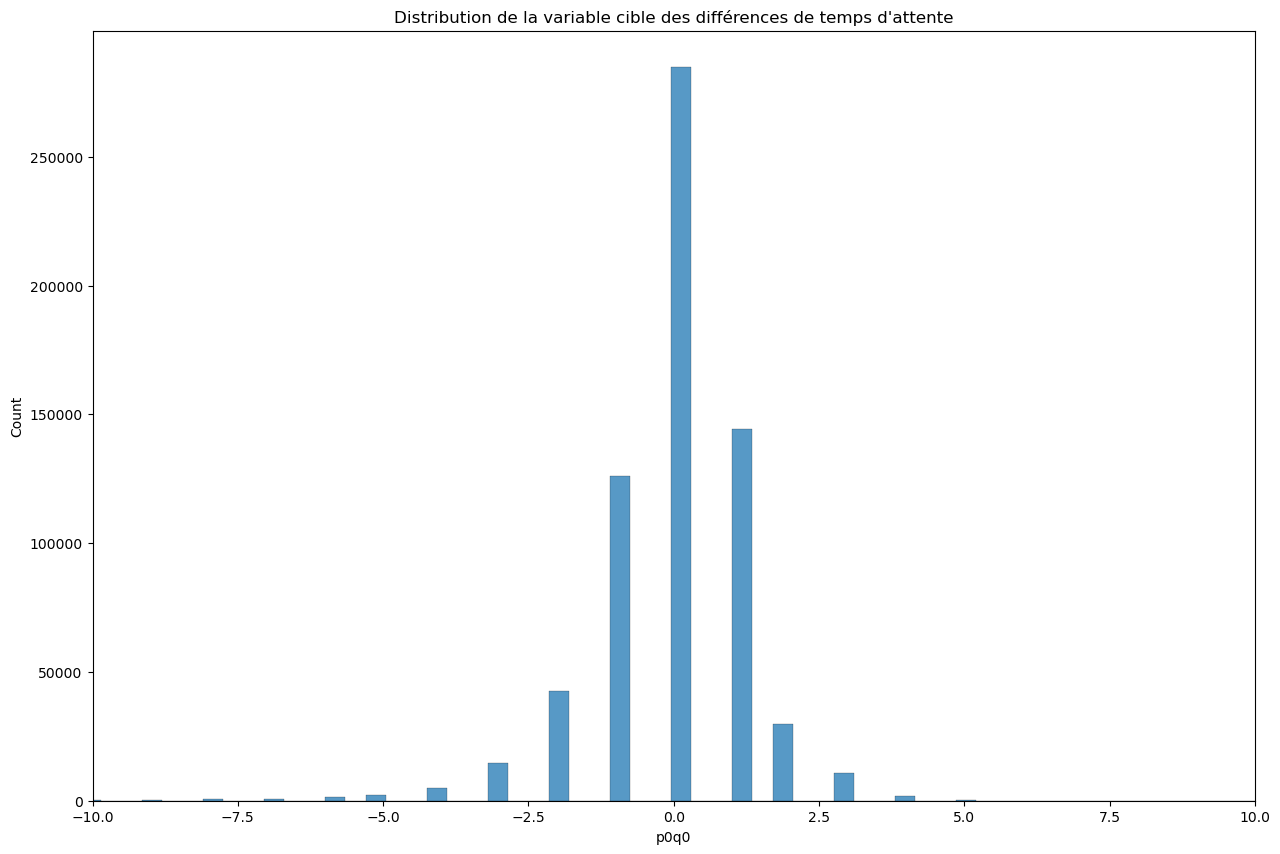

In [6]:
print("INFORMATIONS GÉNÉRALES SUR LE DATASET\n")
print(f"Période couverte: de {x_train['date'].min()} à {x_train['date'].max()}")

# Analyse des variables contextuelles
print("""Variables contextuelles:\n""" + 
      f"- Nombre de trains uniques: {x_train['train'].nunique()}\n" +
      f"- Nombre de gares: {x_train['gare'].nunique()}\n" +
      f"- Distribution des arrêts: {x_train['arret'].value_counts().sort_index().to_dict()}")

# Analyse temporelle
x_train['date'] = pd.to_datetime(x_train['date'])
x_train['jour_semaine'] = x_train['date'].dt.day_name()
print(f"\nDistribution par jour de la semaine: {x_train['jour_semaine'].value_counts()}")

print("ANALYSE DE LA VARIABLE CIBLE\n")
print("Statistiques de la différence de temps d'attente (p0q0):\n")
print(y_train["p0q0"].describe())
# Création des visualisations
plt.figure(figsize=(15, 10))

# Distribution de la variable cible
sns.histplot(y_train["p0q0"], bins=500)
plt.xlim(-10, 10)
plt.title("Distribution de la variable cible des différences de temps d'attente")



#### Informations sur nos features + interprétation

In [7]:
print("Statistiques descriptives des features numériques:\n")
x_train.describe()

Statistiques descriptives des features numériques:



,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
count,667264,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000
mean,2023-07-18 22:14:21.370612480,18.277499,-0.170696,-0.167304,-0.176308,-0.163223,-0.173579,-0.174436
min,2023-04-03 00:00:00,7.000000,-160.000000,-160.000000,-160.000000,-160.000000,-1441.000000,-1441.000000
25%,2023-05-23 00:00:00,12.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,2023-06-23 00:00:00,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-09-27 00:00:00,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2023-11-10 00:00:00,42.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000
std,NaN,7.030424,1.976521,1.960416,1.926275,1.988527,2.643148,4.732999


In [8]:
x_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667264 entries, 0 to 667263
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   train         667264 non-null  object        
 1   gare          667264 non-null  object        
 2   date          667264 non-null  datetime64[ns]
 3   arret         667264 non-null  int64         
 4   p2q0          667264 non-null  float64       
 5   p3q0          667264 non-null  float64       
 6   p4q0          667264 non-null  float64       
 7   p0q2          667264 non-null  float64       
 8   p0q3          667264 non-null  float64       
 9   p0q4          667264 non-null  float64       
 10  jour_semaine  667264 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 56.0+ MB


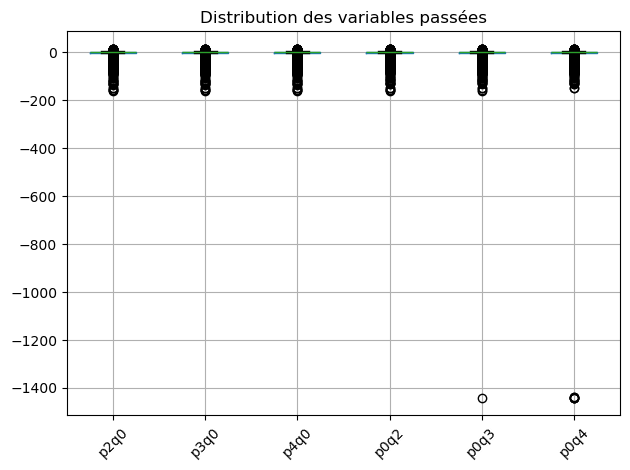

In [9]:
# Boxplot des variables passées
variables_passees = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

x_train[variables_passees].boxplot()
plt.title('Distribution des variables passées')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INTERPRÉTATION DES RÉSULTATS

Observations :
- Les données couvrent plusieurs trains et gares
- La distribution des arrêts montre la structure du réseau

Variables passées:
- Permettent de capturer les retards propagés
- Montrent les corrélations temporelles entre les retards

Variable cible (p0q0):
- Indique la différence entre temps d'attente théorique et réel
- Une valeur négative signifie un temps d'attente plus long que prévu
- Une valeur positive signifie un temps d'attente plus court que prévu

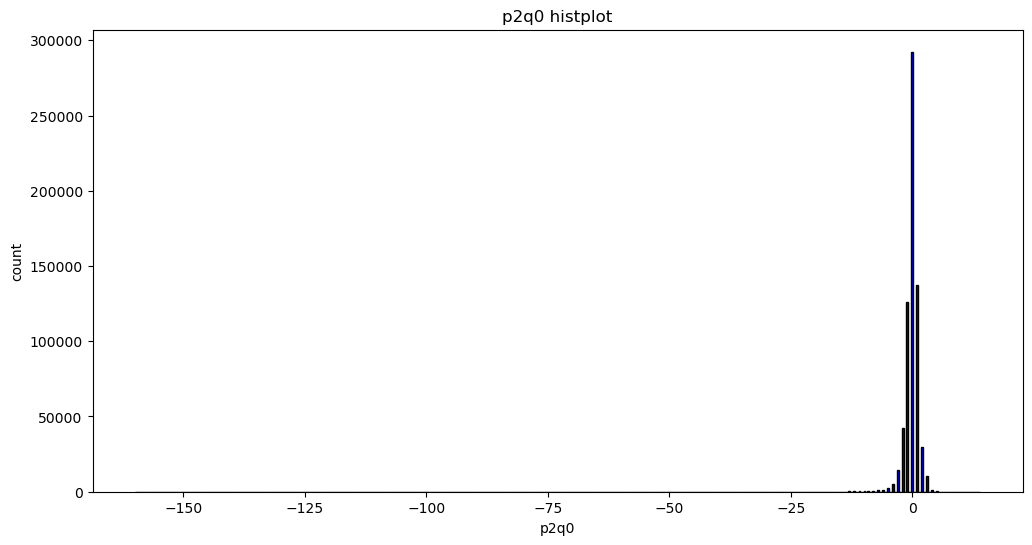

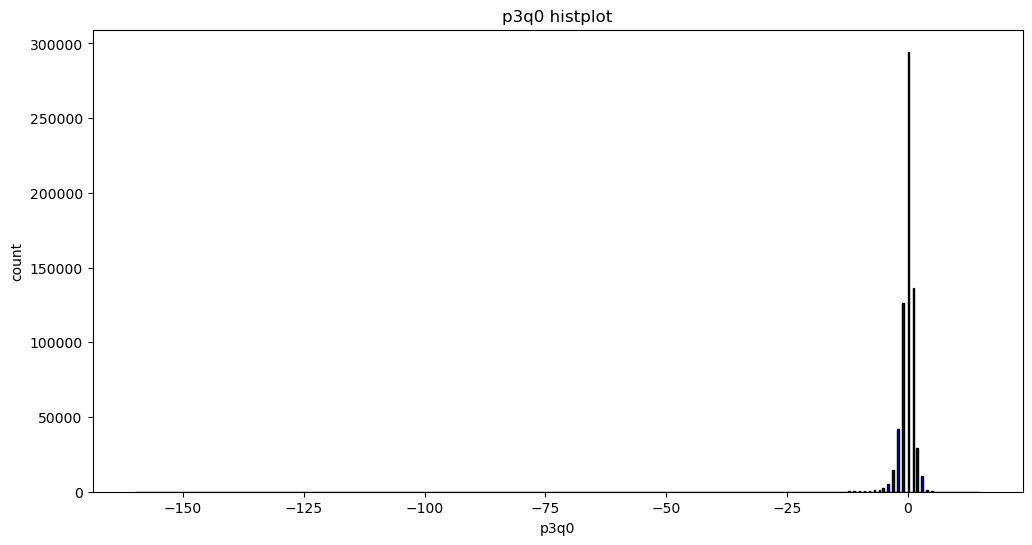

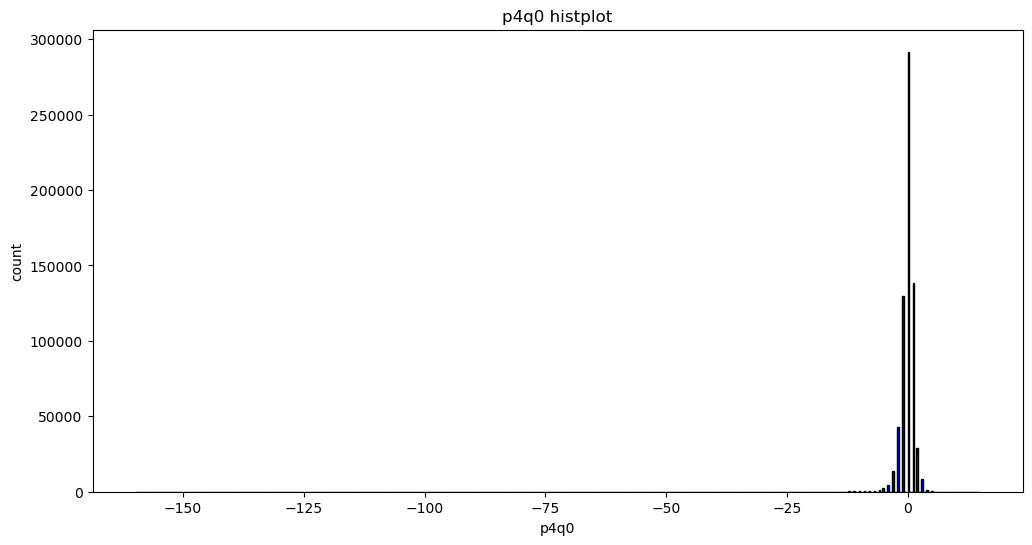

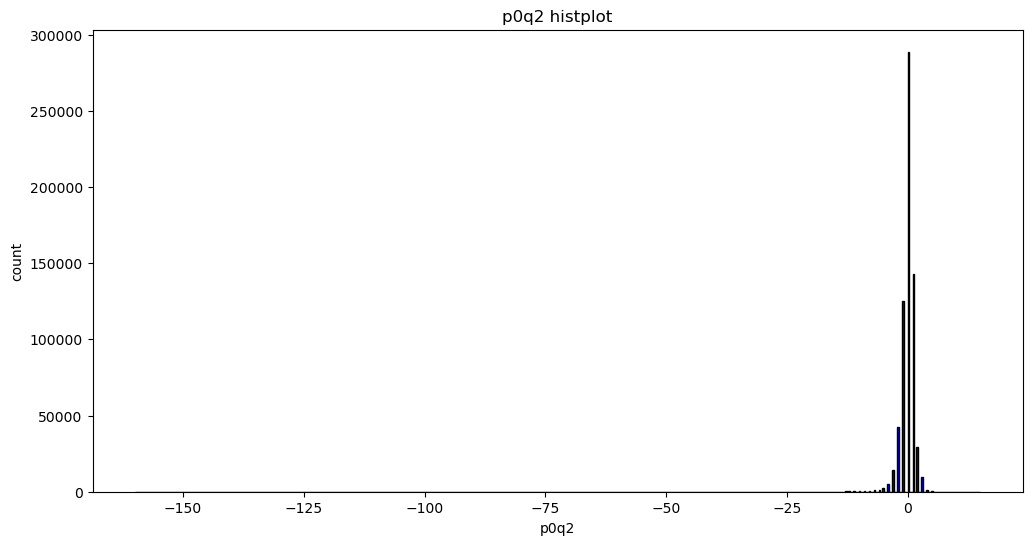

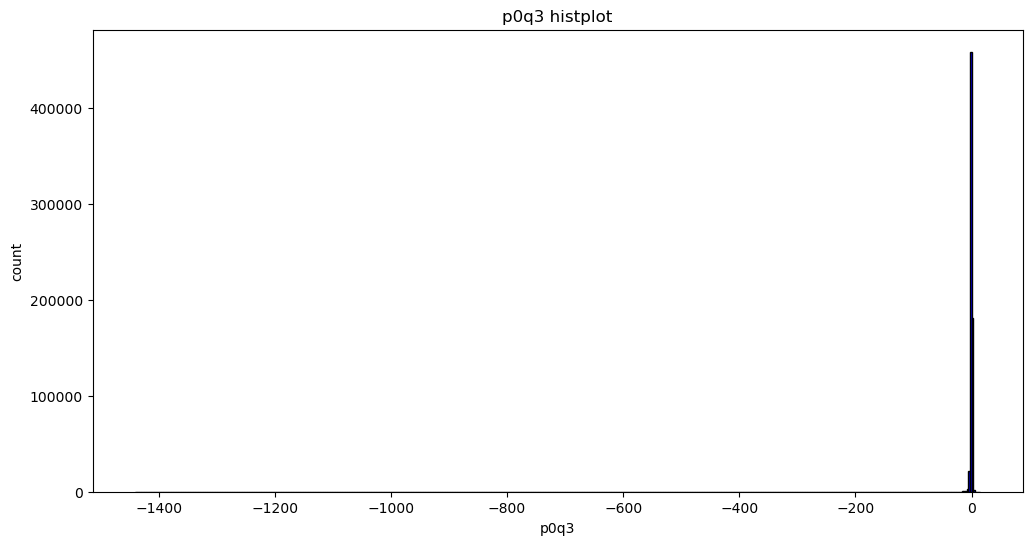

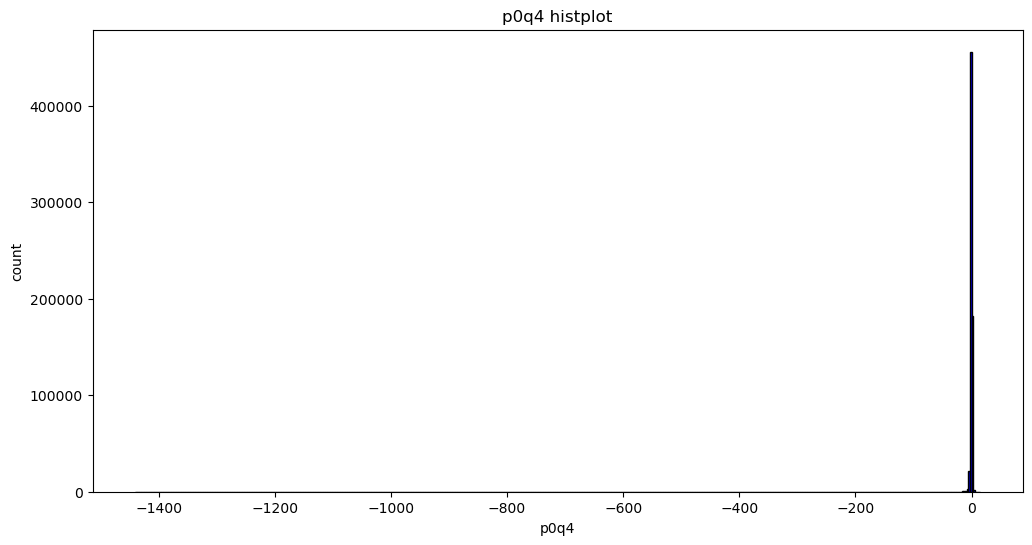

In [10]:
import matplotlib.pyplot as plt

for var in  ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']:
    plt.figure(figsize=(12, 6))
    plt.hist(x_train[var], bins=500, color='blue', edgecolor='black')

    # Ajouter des labels
    plt.xlabel(var)
    plt.ylabel('count')
    plt.title(f'{var} histplot')
    plt.show()


# Création des visualisations
# plt.figure(figsize=(15, 10))

# # Distribution de la variable cible
# plt.subplot(2, 2, 1)
# plt.subplot(2, 2, 2)

Gestion des outliers

In [11]:
def outliers(df, colonnes, multiplicateur=3):
    df_result = df.copy()
    resultats_par_colonne = {}

    for colonne in colonnes:
        Q1 = np.percentile(df_result[colonne], 25)
        Q3 = np.percentile(df_result[colonne], 75)
        IQR = Q3 - Q1

        limite_inf = Q1 - multiplicateur * IQR
        limite_sup = Q3 + multiplicateur * IQR

        # Identifier les outliers
        outliers_inf = df_result[colonne] < limite_inf
        outliers_sup = df_result[colonne] > limite_sup
        print("colonne : ",colonne, " - limite inf : ", limite_inf)
        print("colonne : ",colonne," - limite sup : ", limite_sup)
        # quelle limite prendre ? 25-75 ok ?
        total_outliers = outliers_inf.sum() + outliers_sup.sum()

        # Remplace les outliers par la moyenne des valeurs non-outliers
        valeurs_normales = df_result.loc[~(outliers_inf | outliers_sup), colonne]
        moyenne = valeurs_normales.mean()

        nb_inf = outliers_inf.sum()
        nb_sup = outliers_sup.sum()

        df_result.loc[outliers_inf, colonne] = moyenne
        df_result.loc[outliers_sup, colonne] = moyenne

        resultats_par_colonne[colonne] = f"{nb_inf + nb_sup} valeurs remplacées par la moyenne ({moyenne:.2f})"

    print("Résumé du traitement des outliers:")
    for col, resultat in resultats_par_colonne.items():
        print(f"- {col}: {resultat}")

    return df_result

In [12]:
continuous_features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
outliers(x_train,continuous_features)

colonne :  p2q0  - limite inf :  -7.0
colonne :  p2q0  - limite sup :  7.0
colonne :  p3q0  - limite inf :  -7.0
colonne :  p3q0  - limite sup :  7.0
colonne :  p4q0  - limite inf :  -7.0
colonne :  p4q0  - limite sup :  7.0
colonne :  p0q2  - limite inf :  -7.0
colonne :  p0q2  - limite sup :  7.0
colonne :  p0q3  - limite inf :  -7.0
colonne :  p0q3  - limite sup :  7.0
colonne :  p0q4  - limite inf :  -7.0
colonne :  p0q4  - limite sup :  7.0
Résumé du traitement des outliers:
- p2q0: 2938 valeurs remplacées par la moyenne (-0.10)
- p3q0: 2854 valeurs remplacées par la moyenne (-0.10)
- p4q0: 2730 valeurs remplacées par la moyenne (-0.11)
- p0q2: 3029 valeurs remplacées par la moyenne (-0.09)
- p0q3: 3033 valeurs remplacées par la moyenne (-0.10)
- p0q4: 3022 valeurs remplacées par la moyenne (-0.09)


,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,jour_semaine
0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0,Monday
1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0,Monday
2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0,Monday
3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0,Monday
4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...
667259,BFNJJK,DGG,2023-11-10,22,0.0,-1.0,-6.0,-1.0,0.0,-2.0,Friday
667260,BFNJJK,KDN,2023-11-10,23,0.0,0.0,-1.0,1.0,0.0,0.0,Friday
667261,BFNJJK,TVD,2023-11-10,24,1.0,0.0,0.0,-1.0,-3.0,-1.0,Friday
667262,BFNJJK,TXP,2023-11-10,26,2.0,2.0,1.0,0.0,0.0,1.0,Friday


#### Corrélation entre les features et la cible (V de Cramer ou test Chi-deux ou kruskall-wallis selon si les features et la cible sont continues ou catégorielles)

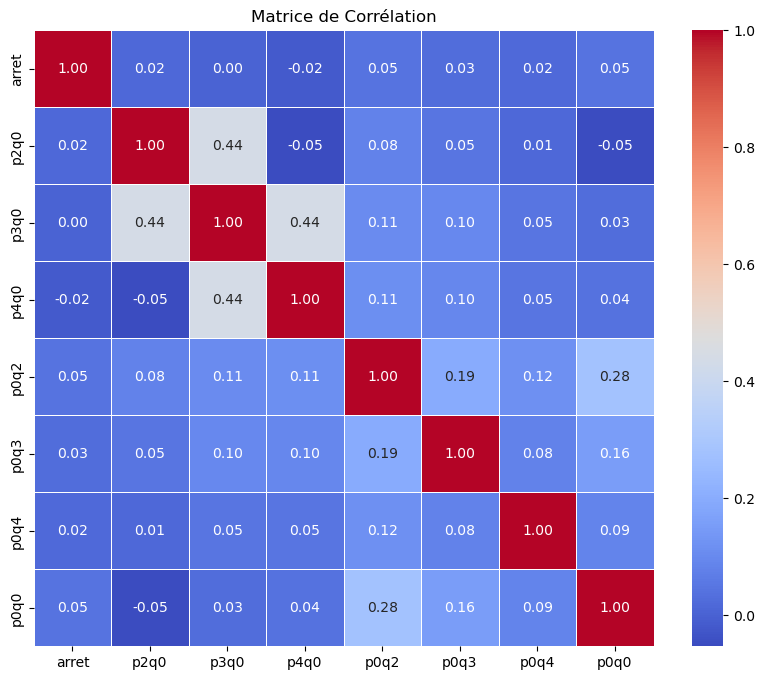

In [13]:
# Feature discrète
cols_numerical = ['arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

cible = ['p0q0']

df_correl = pd.concat([x_train, y_train], axis=1)

correlation_matrix = df_correl[cols_numerical+cible].corr() # pearson

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

In [14]:
cible = 'p0q0'

def cramers_v(x, y):
    # Création d'une table de contingence
    confusion_matrix = pd.crosstab(x, y)
    
    # Calcul du test du Chi²
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    
    # Calcul du V de Cramér
    n = confusion_matrix.sum().sum()  # Nombre total d'observations
    min_dim = min(confusion_matrix.shape) - 1  # Dimension minimale pour normalisation
    return np.sqrt(chi2 / (n * min_dim))

for col in cols_numerical:
    print(col)
    print(cramers_v(x_train[col], y_train[cible]))  # Calcul du V de Cramér

arret
0.048988169225546684
p2q0
0.058806939009152244
p3q0
0.026364683382666163
p4q0
0.030855572288599843
p0q2
0.22132069454325778
p0q3
0.13264719067946604
p0q4
0.15076978917784686


## 4) Traitement et création de nouvelles features

### 4.1) Ajout de nouvelles features et création TRAIN et TEST

- Jour de la Semaine
- Jour particulier (férié, etc.)
- Mois de l'année
- Vacances scolaire
- Météo
- Grèves
- Malaise voyageur 

In [15]:
x_train.columns

Index(['train', 'gare', 'date', 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2',
       'p0q3', 'p0q4', 'jour_semaine'],
      dtype='object')

In [16]:
y_train.columns

Index(['p0q0'], dtype='object')

In [17]:
x_test.columns

Index(['train', 'gare', 'date', 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2',
       'p0q3', 'p0q4'],
      dtype='object')

In [18]:
TRAIN = (x_train, y_train)

TEST = x_test

### 4.2) Normalisation des données

Normaliser nécessairement ? Peux fausser les modèles et leurs performances. Fait sens pour l'ACP, K-means mais pas forcément pour le supervisé

Méthode 1 vue en cours : Voir Task 8 Bankruptcy_Prediction_Part_1_vFinal

In [19]:
def normalize(*arg, columns=None): # df [,min_vals,max_vals] [,columns]
    """ Normalizes the features of a dataframe
    Arguments:
    - 1st argument (mandatory) = df: name of dataframe to normalize
    - 2nd argument (optional): min_vals = list of min value of each feature
    - 3rd argument (optional): max_vals = list of max value of each feature
    - columns (optional keyword arg): list of column names to normalize. If None, normalizes all columns

    If df only is passed, the function normalizes X_ij, i.e. ith value of feature j as:
                               (X_ij - min_j)/(max_j - min_j)                           (1)
    and returns the min_j and max_j lists
    If df, min_vals and max_vals are passed, df is normalized as per (1) using these values
    """
    df = arg[0]
    result = df.copy()

    # Déterminer les colonnes à normaliser
    cols_to_normalize = columns if columns is not None else df.columns

    if len(arg) == 1:
        minval, maxval = [], []
        for feature_name in cols_to_normalize:
            min_value = df[feature_name].min()
            max_value = df[feature_name].max()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            minval.append(min_value)
            maxval.append(max_value)
        return result, minval, maxval
    else:
        minvals = arg[1]
        maxvals = arg[2]
        for i, feature_name in enumerate(cols_to_normalize):
            result[feature_name] = (df[feature_name] - minvals[i]) / (maxvals[i] - minvals[i])
        return result

In [20]:
numeric_cols = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
Xtrain_norm, min_vals, max_vals = normalize(x_train, columns=numeric_cols)
Xtest_norm = normalize(x_test, min_vals, max_vals, columns=numeric_cols)

In [21]:
Xtrain_norm

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,jour_semaine
0,VBXNMF,KYF,2023-04-03,8,0.919540,0.914286,0.920000,0.897143,0.989011,0.988324,Monday
1,VBXNMF,JLR,2023-04-03,9,0.919540,0.914286,0.914286,0.920000,0.989698,0.990385,Monday
2,VBXNMF,EOH,2023-04-03,10,0.913793,0.914286,0.914286,0.908571,0.989698,0.989698,Monday
3,VBXNMF,VXY,2023-04-03,11,0.913793,0.908571,0.914286,0.925714,0.988324,0.989698,Monday
4,VBXNMF,OCB,2023-04-03,12,0.913793,0.908571,0.908571,0.908571,0.991758,0.991071,Monday
...,...,...,...,...,...,...,...,...,...,...,...
667259,BFNJJK,DGG,2023-11-10,22,0.919540,0.908571,0.880000,0.908571,0.989698,0.988324,Friday
667260,BFNJJK,KDN,2023-11-10,23,0.919540,0.914286,0.908571,0.920000,0.989698,0.989698,Friday
667261,BFNJJK,TVD,2023-11-10,24,0.925287,0.914286,0.914286,0.908571,0.987637,0.989011,Friday
667262,BFNJJK,TXP,2023-11-10,26,0.931034,0.925714,0.920000,0.914286,0.989698,0.990385,Friday


Méthode 2 : StandardScaler()

In [22]:
# Création d'un scaler qui va normaliser les données
scaler = StandardScaler()

# Normaliser uniquement les colonnes numériques A T ON BESOIN DE NORMALISER LES AUTRES COLONNES ??
numeric_cols = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

# Fit le scaler sur les données d'entraînement seulement
scaler = StandardScaler()
scaler.fit(x_train[numeric_cols])

x_train_normalized = x_train.copy()
x_test_normalized = x_test.copy()

x_train_normalized[numeric_cols] = scaler.transform(x_train[numeric_cols])
x_test_normalized[numeric_cols] = scaler.transform(x_test[numeric_cols])

# Mise à jour des ensembles TRAIN et TEST avec les données normalisées
TRAIN = (x_train_normalized, y_train)
TEST = x_test_normalized

In [23]:
x_train_normalized

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,jour_semaine
0,VBXNMF,KYF,2023-04-03,8,0.086362,0.085341,0.610665,-1.426573,-0.312666,-0.385710,Monday
1,VBXNMF,JLR,2023-04-03,9,0.086362,0.085341,0.091528,0.584968,0.065671,0.248138,Monday
2,VBXNMF,EOH,2023-04-03,10,-0.419578,0.085341,0.091528,-0.420803,0.065671,0.036855,Monday
3,VBXNMF,VXY,2023-04-03,11,-0.419578,-0.424755,0.091528,1.087853,-0.691003,0.036855,Monday
4,VBXNMF,OCB,2023-04-03,12,-0.419578,-0.424755,-0.427609,-0.420803,1.200682,0.459421,Monday
...,...,...,...,...,...,...,...,...,...,...,...
667259,BFNJJK,DGG,2023-11-10,22,0.086362,-0.424755,-3.023295,-0.420803,0.065671,-0.385710,Friday
667260,BFNJJK,KDN,2023-11-10,23,0.086362,0.085341,-0.427609,0.584968,0.065671,0.036855,Friday
667261,BFNJJK,TVD,2023-11-10,24,0.592302,0.085341,0.091528,-0.420803,-1.069340,-0.174427,Friday
667262,BFNJJK,TXP,2023-11-10,26,1.098241,1.105533,0.610665,0.082083,0.065671,0.248138,Friday


### 4.3) Traitement des valeurs manquantes (Imputation)

In [24]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667264 entries, 0 to 667263
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   train         667264 non-null  object        
 1   gare          667264 non-null  object        
 2   date          667264 non-null  datetime64[ns]
 3   arret         667264 non-null  int64         
 4   p2q0          667264 non-null  float64       
 5   p3q0          667264 non-null  float64       
 6   p4q0          667264 non-null  float64       
 7   p0q2          667264 non-null  float64       
 8   p0q3          667264 non-null  float64       
 9   p0q4          667264 non-null  float64       
 10  jour_semaine  667264 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 56.0+ MB


### 4.4) Rééquilibrage de la base si besoin

## 5) Sélection du modèle

#### Encoding des variables catégorielles

In [25]:
cols_categorical = ['train','gare']

label_encoders = {}
for col in cols_categorical:
    le = LabelEncoder()
    x_train[col] = le.fit_transform(x_train[col])  # Transformation
    x_test[col] = le.fit_transform(x_test[col])
    label_encoders[col] = le

# Conversion de la date en features temporelles
def prepare_data(X, columns):
    # Préparation des features
    X = X[columns]

    # Conversion de la date en features temporelles
    X['date'] = pd.to_datetime(X['date'])
    X['jour_semaine'] = X['date'].dt.dayofweek
    X['mois'] = X['date'].dt.month

    # Suppression de la colonne date originale après extraction des features
    X = X.drop('date', axis=1)

    return X

x_train = prepare_data(x_train, feature_columns)
x_test = prepare_data(x_test, feature_columns)


In [26]:
print(x_train.head())
print(x_test.head())

   train  gare  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4  jour_semaine  mois
0  30536    34      8   0.0   0.0   1.0  -3.0  -1.0  -2.0             0     4
1  30536    26      9   0.0   0.0   0.0   1.0   0.0   1.0             0     4
2  30536    14     10  -1.0   0.0   0.0  -1.0   0.0   0.0             0     4
3  30536    68     11  -1.0  -1.0   0.0   2.0  -2.0   0.0             0     4
4  30536    43     12  -1.0  -1.0  -1.0  -1.0   3.0   2.0             0     4
   train  gare  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4  jour_semaine  mois
0   7925    65     12   0.0   0.0  -2.0  -4.0  -2.0  -4.0             0    11
1   3228    65     12   0.0   0.0  -1.0   1.0  -1.0   0.0             0    11
2   5094    65     12   0.0   1.0  -1.0   1.0  -1.0   1.0             0    11
3   1835    65     12   0.0   0.0  -1.0  -1.0   0.0  -1.0             0    11
4   2159     5     12   1.0  -2.0   0.0   0.0   0.0   0.0             0    11


#### Split

In [27]:
from sklearn.model_selection import train_test_split

# Fractionner les données (80% train, 20% test par défaut)
X_fill_train, X_fill_test, y_fill_train, y_fill_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Afficher les dimensions pour vérification
print(f"X_fill_train: {X_fill_train.shape}, X_fill_test: {X_fill_test.shape}")
print(f"y_fill_train: {y_fill_train.shape}, y_fill_test: {y_fill_test.shape}")


X_fill_train: (533811, 11), X_fill_test: (133453, 11)
y_fill_train: (533811, 1), y_fill_test: (133453, 1)


Nous allons donc tester plusieurs modèles sur nos données d'entrainement pour trouver celui qui maximisera la MAE de notre prediction. Nous nous concentrerons sur des modèles de regression

In [ ]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    #'Support Vector Regression': SVR(), besoin de normaliser la data
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_fill_train, y_fill_train)
    # Évaluation du modèle
    y_pred = model.predict(X_fill_test)
    mae = mean_absolute_error(y_fill_test, y_pred)
    r2 = r2_score(y_fill_test, y_pred)    
    # Validation croisée (10-fold)
    cv_scores = sk.model_selection.cross_val_score(model, X_fill_train, y_fill_train, cv=10, scoring='neg_mean_squared_error')
    res.append([mod.__class__.__name__,mae,r2,cv_scores])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso
Model: ElasticNet
Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: GradientBoostingRegressor
Model: KNeighborsRegressor


In [95]:
res = pd.DataFrame(res,columns=["model","mae","r2","cv_score"]).sort_values(by="mae",ascending=True) # plus c'est petit mieux c'est
res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(5)

,model,mae,r2,cv_score,cv_mean
0,XGBRegressor,0.746881,0.215129,"[-3.2471638314477884, -2.9630215472106696, -3....",-3.167550
6,RandomForestRegressor,0.784215,0.157321,"[-3.521554100633172, -3.2601908263239725, -3.7...",-3.396995
7,GradientBoostingRegressor,0.822268,0.164145,"[-3.463933785735896, -3.0871479249198526, -3.5...",-3.312426
1,LinearRegression,0.881699,0.115087,"[-3.7323946967361543, -3.353242378092799, -3.7...",-3.629052
2,Ridge,0.881699,0.115087,"[-3.7323946086440105, -3.3532423272190046, -3....",-3.629052


Nous constatons que le modèle XGBoost prédit des valeurs avec la MAE la plus faible donc nous allons choisir ce type modèle pour nos predictions. Mais avant de passer à la prédiction, nous allons optimiser les hyperparamètres de ce modèle.

##### **Optimisation des hyperparamètres**

In [98]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2,0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree': [0.2,0.4,0.6, 0.8, 1.0]
}

grid_search = sk.model_selection.GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_fill_train, y_fill_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


MemoryError: Unable to allocate 16.3 MiB for an array with shape (6, 355874) and data type float64

#### Problème out of memory : optuna

In [28]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Définir la fonction d'optimisation
def objective(trial):
    # Définition des hyperparamètres à optimiser
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0, step=0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0, step=0.2),
    }

    # Modèle XGBoost avec ces paramètres
    model = XGBRegressor(**params)

    # Évaluation avec validation croisée (R² score)
    score = cross_val_score(model, X_fill_train, y_fill_train, cv=3, scoring="r2", n_jobs=-1)
    
    return score.mean()  # On maximise le R²

# Lancer l'optimisation
study = optuna.create_study(direction="maximize")  # Maximiser le R²
study.optimize(objective, n_trials=100, n_jobs=-1)

# Meilleurs hyperparamètres et meilleur modèle
best_params = study.best_params
best_score = study.best_value

print("Meilleurs paramètres:", best_params)
print("Meilleur R²:", best_score)

# Entraîner le modèle final avec les meilleurs paramètres
best_model = XGBRegressor(**best_params)
best_model.fit(X_fill_train, y_fill_train)


[I 2025-03-06 14:48:09,552] A new study created in memory with name: no-name-9cb0ca53-bbe3-4440-a5b2-cbce6769271d
[I 2025-03-06 14:48:18,557] Trial 1 finished with value: 0.1526052157084147 and parameters: {'n_estimators': 50, 'learning_rate': 0.11, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.4}. Best is trial 1 with value: 0.1526052157084147.
[I 2025-03-06 14:48:20,764] Trial 3 finished with value: 0.16458014647165933 and parameters: {'n_estimators': 50, 'learning_rate': 0.26, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}. Best is trial 3 with value: 0.16458014647165933.
[I 2025-03-06 14:48:21,594] Trial 2 finished with value: 0.0906359354654948 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}. Best is trial 3 with value: 0.16458014647165933.
[I 2025-03-06 14:48:26,506] Trial 5 finished with value: 0.1786722739537557 and parameters: {'n_estimators': 100, 'learn

Meilleurs paramètres: {'n_estimators': 200, 'learning_rate': 0.060000000000000005, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 0.4}
Meilleur R²: 0.21275528271993002


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.060000000000000005,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred_best = best_model.predict(X_fill_test)
best_mae = mean_absolute_error(y_fill_test, y_pred_best)
best_r2 = r2_score(y_fill_test, y_pred_best)

print(f"Best Absolute Error: {best_mae}")
print(f"Best R^2 Score: {best_r2}")

best_cv_scores = sk.model_selection.cross_val_score(best_model, X_fill_train, y_fill_train, cv=5, scoring='neg_mean_squared_error')
print(f"Best Cross-Validation Scores (neg MSE): {best_cv_scores}")
print(f"Mean Best Cross-Validation Score (neg MSE): {best_cv_scores.mean()}")

Best Absolute Error: 0.7436327934265137
Best R^2 Score: 0.2305949330329895
Best Cross-Validation Scores (neg MSE): [-2.99795246 -3.06122828 -3.12142372 -2.99822903 -3.17147136]
Mean Best Cross-Validation Score (neg MSE): -3.070060968399048


Avec notre optimisation d'hyperparamètre, nous avons identifié un modèle qui est plus précis. Nous le retiendrons donc pour la prédiction de ...

In [30]:
print('Hyperparamètres optimaux :')
best_params

Hyperparamètres optimaux :


{'n_estimators': 200,
 'learning_rate': 0.060000000000000005,
 'max_depth': 9,
 'subsample': 1.0,
 'colsample_bytree': 0.4}

### SUBMISSION TEST

In [31]:
best_params ={'colsample_bytree': 0.4,
            'learning_rate': 0.1,
            'max_depth': 9,
            'n_estimators': 200,
            'subsample': 1.0,
            'n_jobs':-1}

xgb = XGBRegressor(**best_params)

xgb.fit(x_train,y_train)
y_test=pd.DataFrame()
y_test['p0q0'] = xgb.predict(x_test)
y_test.to_csv("data/try_submit.csv") # sur le challenge >>> 0.88 MAE


## 5) Benchmark

##### **Mesure de performance demandée par le challenge**

- On recréera le benchmark qui est une random forest classique


Nous adaptons également cette metrique pour qu'elle soit utilisable dans nos GridSearch au moment de l'optimisation de nos hyperparamètre.

In [29]:
custom_score = make_scorer(mean_absolute_error, greater_is_better=False)

##### **Création et Entrainement du modèle**

In [33]:
comparaison=[]
result_baseline=[]

baseline_model = RandomForestRegressor(n_jobs=-1, random_state=42)
baseline_model.fit(X_fill_train, y_fill_train)

# Prédictions et évaluation
y_pred_baseline = baseline_model.predict(X_fill_test)

# Mesure de Performance
wacc_baseline = mean_absolute_error(y_fill_test['p0q0'], y_pred_baseline)
print(f"Baseline model MAE: {wacc_baseline}")

Baseline model MAE: 0.7828526147782365


Interprétations: En moyenne le modèle (RF) se trompe de 0.78 minutes (46 secondes)

##### **Optimisation des hyperparamètre**

pas utiliser, on n'a pas split en 3 set car on fait un random forest 
"Nous garderons donc la methode 2 pour cette optimisation car c'est celle pour laquelle le modèle est le plus performant."

In [ ]:
# X_train_method,y_train_method = methods[2]
# X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
# y_train_method_train = (y_train_method_train['cible'] > 0).astype(int)


### Pas run: trop long

In [ ]:
param_grid = {
    'max_iter': [100, 200, 500, 1000, 2000],  # Nombres d'itérations
    'C': [0.001, 0.01, 0.1, 1, 10, 100],      # Paramètre de régularisation
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithmes d'optimisation
}

# Configuration de la recherche en grille avec validation croisée
grid_search = sk.model_selection.GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_fill_train, y_fill_train)

# Meilleur modèle et paramètres
baseline_model = grid_search.best_estimator_
print("Meilleur modèle:", baseline_model)

Meilleur modèle: LogisticRegression(C=0.001, random_state=42, solver='newton-cg')


In [ ]:
y_pred_optimized = baseline_model.predict(X_fill_test)
wacc_baseline = mean_absolute_error(y_fill_test['p0q0'], y_pred_optimized)
comparaison.append(["Methode_baseline","LogisticRegression",wacc_baseline])
wacc_baseline

0.6437786569846814

Interprétation

##### **Prédiction des valeurs**

In [ ]:
y_test_baseline = baseline_model.predict(X_fill_test)
y_test_baseline = pd.DataFrame(y_test_baseline,index=X_fill_test.index,columns=['p0q0'])
y_test_baseline.to_csv('y_test_baseline.csv')

Nous avons testé ce résultat et nous obtenons bien le même résultats que le benchmark. 

## 7) Modèle non supervisé si possible ou à dafaut pour construire des features

Avec une méthode d'apprentissage non supervisée, on ne pourraient pas prédire directement le cible. Mais on peut envisager de l'utiliser pour explorer ou prétraiter les données avant d'utiliser un modèle supervisé.

Nous utiliserons donc d'abord une Décomposition en Composante Principales pour observer nos données, puis utiliserons un Kmeans pour regrouper nos données afin d'améliorer nos résultats de nos modèles supervisés. 

### 6.1) ACP

Nous commençons par appliquer une ACP sur nos données pour réduire le nombre de dimensions. Nous affichons la reprensentation de notre nuage de points sur 3 dimensions et la courbe de la variance expliquée en fonction du nombre de dimensions choisis pour notre décomposition.

In [30]:
# normaliser

X_train_method = x_train.copy(deep=True) #pd.concat([x_train,y_train],axis=1)

X_test_method = x_test.copy(deep=True)

y_train_method = y_train.copy(deep=True)

se_collector = {"train":[],"gare":[],"arret":[],"p2q0":[],"p3q0":[],"p4q0":[],"p0q2":[],"p0q3":[],"p0q4":[],"jour_semaine":[],"mois":[] }#,"p0q0":[]}

for col in X_train_method.columns:
    se = StandardScaler()
    X_train_method[col] = se.fit_transform(X_train_method[[col]])
    se_collector[col] = se

se_test_collector = {"train":[],"gare":[],"arret":[],"p2q0":[],"p3q0":[],"p4q0":[],"p0q2":[],"p0q3":[],"p0q4":[],"jour_semaine":[],"mois":[]}

for col in X_test_method.columns:
    se = StandardScaler()
    X_test_method[col] = se.fit_transform(X_test_method[[col]])
    se_test_collector[col] = se

se = StandardScaler()
se_y_collector = {'p0q0':[]}

y_train_method['p0q0'] = se.fit_transform(y_train_method[['p0q0']])
se_test_collector['p0q0'] = se

methods = [("Stardard",X_train_method, y_train_method,X_test_method)]

Variance expliquée : [0.15600221 0.26300695 0.35937555 0.45319256 0.54432475 0.63519879
 0.72379158 0.81139829 0.89548903 0.96818897 1.        ]


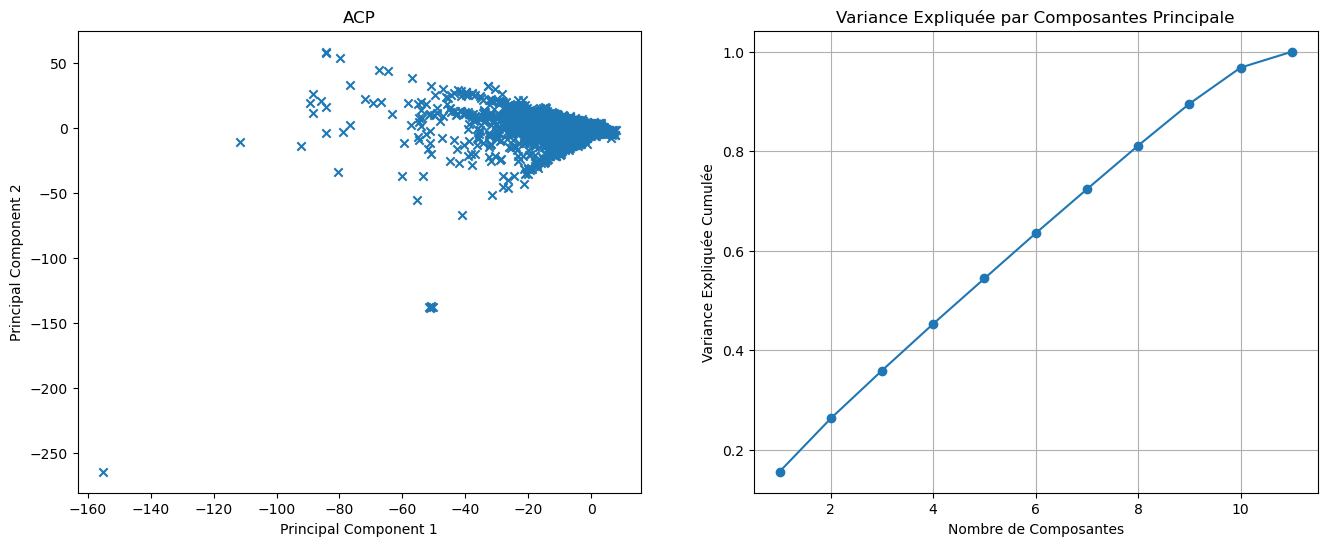

In [31]:
result_kmeans = []
from sklearn.decomposition import PCA

# PCA pour la réduction de dimensions
pca = PCA() #Pour affichage graphique
x_train_pca = pca.fit_transform(X_train_method)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance expliquée : {cumulative_variance}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
# Visualisation des clusters

axes[0].scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1],marker="x")
axes[0].set_title(f"ACP")
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Visualisation de l'évolution de la variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
axes[1].set_xlabel('Nombre de Composantes')
axes[1].set_ylabel('Variance Expliquée Cumulée')
axes[1].set_title(f'Variance Expliquée par Composantes Principale')
axes[1].grid(True)
plt.show()
   

Observations :
* La courbe montre une augmentation linéaire de la varianceexpliquée et ce jusqu'à 12 composantes après quoi on a une variance expliquée de 100%. On peut dire que les premières compsoantes ne capturent pas bien les informations les plus importantes

* Pour expliquer plus de 95% de la variance, nous devons garder au minimum 11.

### 6.2) Kmeans

#### 6.2.1) Ajout de Features

Nous allons utiliser un kmeans pour regrouper nos données en cluster et leur ajouter des données qui pourraient être utiles dans notre analyse. Nous pouvons ajouter des valeurs sur les centres de gravité de nos données, ou sur des moyennes des valeur de nos cluster comme celle du *predicted_spot_price*. Nous allons donc génerer ces deux features et tester ces nouvelles méthodes de données dans la suite de notre travail. 

Exception in thread Thread-18 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lince\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\lince\anaconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lince\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x90 in position 25: invalid start byte
  File "c:\Users\lince\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^


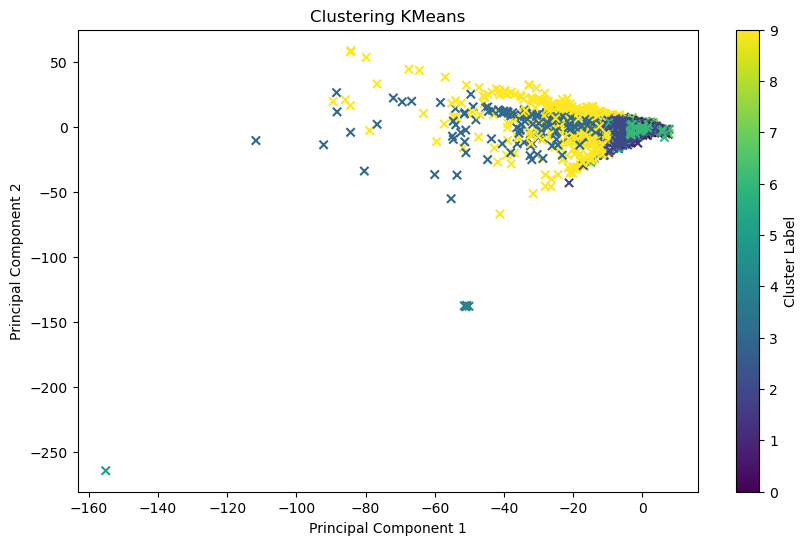

In [32]:
methods_features=[]
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(X_train_method)
x_test_pca = pca.transform(X_test_method)

# KMeans Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(x_train_pca)
clusters = kmeans.predict(x_train_pca)
clusters_test = kmeans.predict(x_test_pca)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1], c=clusters, marker= 'x', cmap='viridis')
plt.title(f"Clustering KMeans")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# ajout des centroids et cluster aux données existantes
x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)
x_test_pca = pd.DataFrame(x_test_pca,index=X_test_method.index)
clusters = pd.DataFrame(clusters,index=X_train_method.index,columns=['cluster'])
clusters_test = pd.DataFrame(clusters_test,index=X_test_method.index,columns=['cluster'])
centroids = kmeans.cluster_centers_
for i,c in enumerate(centroids) :
    for j in range(len(c)):
        clusters.loc[clusters.cluster==i,f'cluster_{j}'] = c[j]
        clusters_test.loc[clusters_test.cluster==i,f'cluster_{j}'] = c[j]
data_cluster = pd.concat([X_train_method,clusters],axis=1)
data_cluster_test = pd.concat([X_test_method,clusters_test],axis=1)
methods_features.append(('Cluster',data_cluster,y_train_method,data_cluster_test))

# ajout de la moyenne
data_cluster_1 = X_train_method.copy()
data_cluster_1['mean_idk_cluster'] = data_cluster.groupby('cluster')['cluster_1'].transform('mean')
data_cluster_test_1 = X_test_method.copy()
data_cluster_test_1['mean_idk_cluster'] = data_cluster_test.groupby('cluster')['cluster_1'].transform('mean')
methods_features.append(('Mean',data_cluster_1,y_train_method,data_cluster_test_1))


In [33]:
methods = methods + methods_features

In [34]:
methods

[('Stardard',
             train      gare     arret      p2q0      p3q0      p4q0      p0q2  \
  0       1.089803 -0.291152 -1.461862  0.086362  0.085341  0.610665 -1.426573   
  1       1.089803 -0.618431 -1.319623  0.086362  0.085341  0.091528  0.584968   
  2       1.089803 -1.109350 -1.177384 -0.419578  0.085341  0.091528 -0.420803   
  3       1.089803  1.099786 -1.035145 -0.419578 -0.424755  0.091528  1.087853   
  4       1.089803  0.077038 -0.892905 -0.419578 -0.424755 -0.427609 -0.420803   
  ...          ...       ...       ...       ...       ...       ...       ...   
  667259 -1.569846 -1.272990  0.529485  0.086362 -0.424755 -3.023295 -0.420803   
  667260 -1.569846 -0.413881  0.671724  0.086362  0.085341 -0.427609  0.584968   
  667261 -1.569846  0.813416  0.813963  0.592302  0.085341  0.091528 -0.420803   
  667262 -1.569846  0.854326  1.098441  1.098241  1.105533  0.610665  0.082083   
  667263 -1.569846  0.240678  1.382919  0.592302  0.595437  1.129802 -2.432343   
  

##### **Etudes de nouvelles données**

Pour les deux premières methodes, les nouvelles données sont très peu corrélée avec la variable cible. Mais pour notre méthode 3, les données sont un peu plus corrélées et apportent des informations supplémentaire. Nous les garderons donc pour nos prévisions.

#### 6.2.2) Prediction après clustering

Nous allons utiliser un Kmeans pour faire une prédictions de notre variable cible.

In [39]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=20, random_state=42)
    kmeans.fit(x_train_pca)
    x_train_pca['cluster'] = kmeans.predict(x_train_pca)

    # Compute y_pred as means of cluster for training
    x_train_pca = pd.concat([x_train_pca,y_train_method],axis=1)
    groups = x_train_pca.groupby(by='cluster')
    map_y = {}
    for nb,group in groups:
        map_y[nb] = group.p0q0.mean()
    x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

    # compute metrics
    w_acc = mean_absolute_error(y_train_method["p0q0"],x_train_pca['y_pred'])
    result_kmeans.append([f"Methode_{nom}",20,w_acc,kmeans,map_y,pca])
result_kmeans=pd.DataFrame(result_kmeans,columns=['Methode','nb_composante','MAE','Model','Map','PCA'])

In [40]:
result_kmeans

,Methode,nb_composante,MAE,Model,Map,PCA
0,Methode_Stardard,20,0.477432,"KMeans(n_clusters=20, random_state=42)","{0: 0.10436146176031597, 1: -0.036745021784274...",PCA()
1,Methode_Cluster,20,0.484136,"KMeans(n_clusters=20, random_state=42)","{0: 0.03802705376721095, 1: -0.259473635742907...",PCA()
2,Methode_Mean,20,0.477352,"KMeans(n_clusters=20, random_state=42)","{0: 0.06736568565771087, 1: -0.050156547816774...",PCA()


##### **Optimisation**

On va utiliser le set d'indice 2 car c'est celui avec la MAE la plus faible

In [ ]:
# Fonction pour calculer le score de silhouette pour un nombre de clusters donné
from sklearn.metrics import silhouette_score

def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    return score

score_sil = []
kmax = 5
for k in range(2, kmax, 2):
    result = compute_silhouette_score(k, methods[2][1])
    print(result)
    score_sil.append(result)


# Afficher les scores de silhouette
#k_values, silhouette_scores_home = zip(*[(result[0], result[1]) for result in score_sil])
plt.figure(figsize=(10, 6))
plt.plot([k for k in range(2, kmax,2)],score_sil, marker='o')
plt.title('Silhouette Score for different numbers of clusters (Home)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Extraire les meilleurs résultats
score = max(score_sil)
k_ideal = score_sil.index(score) +2
print(f"Meilleur nb de cluster :",k_ideal," pour un score de ",score)


Le score de silhouette nous donne 2 comme nombre de cluster idéal. Cependant, pour le bien de la prediction, nous allons en prendre plus et vérifier si les performances sont meilleures.

In [ ]:
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(X_train_method)
x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)

# KMeans Clustering
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(x_train_pca)
x_train_pca['cluster'] = kmeans.predict(x_train_pca)

# Compute y_pred as means of cluster for training
x_train_pca = pd.concat([x_train_pca,y_train_method],axis=1)
groups = x_train_pca.groupby(by='cluster')
map_y = {}
for nb,group in groups:
    map_y[nb] = group["p0q0"].mean()
x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

# compute metrics
w_acc = mean_absolute_error(y_train_method["p0q0"],x_train_pca['y_pred'])
comparaison.append([f"Methode_Standard","Kmeans",w_acc])
w_acc

0.7396118154884794

Nous obtenons bien une meilleure performance en prédiction, donc nous retenons ce modèle.

##### **Prediction du *cible***

In [ ]:
model = kmeans
X_test_Kmeans = X_test_method.copy()
X_test_Kmeans = pd.DataFrame(pca.transform(X_test_Kmeans),index=X_test_Kmeans.index)
X_test_Kmeans['cluster'] = kmeans.predict(X_test_Kmeans)
X_test_Kmeans['p0q0'] = X_test_Kmeans['cluster'].apply(lambda x : map_y[x])
y_test_Kmeans = X_test_Kmeans[['p0q0']]
y_test_Kmeans

In [52]:
y_test_Kmeans.to_csv('y_test_Kmeans.csv')

Après soummission, nous obtenons une weighted accuracy de 0,5209416312886466.

## 7) Modèle supervisé

### 7.1) Classification

Dans cette partie, nous allons tester plusieurs modèle de classification différents et comparer notre accuracy pour nos 3 methodes de données afin de trouver le modèle le plus performants.

##### **Selection des modèles**

Il faut discretiser y_train. On peut utiliser une conversion en entier relatif (avec le signe). Nous avons choisi de prendre la valeur entière la plus proche que nous avons plafonnée entre -15 et 20.

In [ ]:
result_supervised = []

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = X_fill_train, X_fill_test, y_fill_train, y_fill_test

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf_model.fit(X_train_method_train, y_train_method_train)
y_pred_rf = rf_model.predict(X_train_method_test)
weighted_acc_rf = mean_absolute_error(y_train_method_test['p0q0'], y_pred_rf)
result_supervised.append((f"Methode_{nom}","RF",weighted_acc_rf,rf_model))

In [ ]:
# SVM
nom,X_train_method,y_train_method,X_test_method=methods[1]
X_train_method_train_normalise, X_train_method_test_normalise, y_train_method_train_normalise, y_train_method_test_normalise = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
svm_model = SVC(random_state=42)
svm_model.fit(X_train_method_train_normalise, y_train_method_train_normalise)
y_pred_svm = svm_model.predict(X_train_method_test_normalise)
weighted_acc_svm = mean_absolute_error(y_train_method_test_normalise['p0q0'], y_pred_svm)
result_supervised.append((f"Methode_{nom}","SVM",weighted_acc_svm,svm_model))

In [ ]:
# Regression logistique
rl_model = LogisticRegression(multi_class='multinomial',n_jobs=-1,random_state=42)
rl_model.fit(X_train_method_train, y_train_method_train)
y_pred_rl = rl_model.predict(X_train_method_test)
weighted_acc_rl = mean_absolute_error(y_train_method_test['p0q0'], y_pred_rl)
result_supervised.append((f"Methode_{nom}","Logistic",weighted_acc_rl,rl_model))


In [ ]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn_model.fit(X_train_method_train, y_train_method_train)
y_pred_knn = knn_model.predict(X_train_method_test)
weighted_acc_knn = mean_absolute_error(y_train_method_test['p0q0'], y_pred_knn)
result_supervised.append((f"Methode_{nom}","KNN",weighted_acc_knn,knn_model))

result_supervised=pd.DataFrame(result_supervised,columns=[f"Methode","Type","W_Accuracy","Modele"])
result_supervised.sort_values('W_Accuracy',inplace=True)

In [54]:
result_supervised

,Methode,Type,W_Accuracy,Modele
5,Methode_Cluster,SVM,0.496633,SVC(random_state=42)
1,Methode_Stardard,SVM,0.522721,SVC(random_state=42)
9,Methode_Mean,SVM,0.524486,SVC(random_state=42)
10,Methode_Mean,Logistic,0.559814,LogisticRegression(multi_class='multinomial')
7,Methode_Cluster,KNN,0.571941,KNeighborsClassifier()
2,Methode_Stardard,Logistic,0.572484,LogisticRegression(multi_class='multinomial')
6,Methode_Cluster,Logistic,0.574568,LogisticRegression(multi_class='multinomial')
11,Methode_Mean,KNN,0.579165,KNeighborsClassifier()
3,Methode_Stardard,KNN,0.585006,KNeighborsClassifier()
0,Methode_Stardard,RF,0.788814,"(DecisionTreeClassifier(max_features='sqrt', r..."


Avec nos resultats, le modèle de Random Forest avec la methode de données 3 parait la plus performante. Nous allons donc retenir ces choix et faire une optimisation des hyperparamètres afin de trouver le modèle le plus performant.

##### **Optimisation des hyperparamètre**

In [56]:
nom,X_train_method,y_train_method,X_test_method = methods[1]
nom = 'Cluster'

In [57]:
X_train_train, X_train_test, y_train_train, y_train_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
y_train_train = np.clip(y_train_method_train.astype(int), -15, 20)
 #y_train_train.astype(int)['cible']

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer à chaque division
    'max_depth': [None, 10, 15],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5],  # Nombre minimum de données nécessaires pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum de données requises à chaque feuille
}

rf = RandomForestClassifier(random_state=42)
grid_search = sk.model_selection.GridSearchCV(estimator=rf, param_grid=param_grid,scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_train, y_train_train)
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
model_rf = grid_search.best_estimator_
pred = model_rf.predict(X_train_test)
weighted_acc = mean_absolute_error(y_train_test['p0q0'], pred)
comparaison.append([f"Methode_{nom}","RandomForestClassifier",weighted_acc])
weighted_acc

0.8144037628426313

In [60]:
#model_rf.get_params()

##### **Prediction sur nos données X_test**

In [ ]:
y_test_final = model_rf.predict(X_test_method)
y_test_final = pd.DataFrame(y_test_final,index=X_test_method.index,columns=["p0q0"])
y_test_final.to_csv("y_rf.csv")

Sur la plateforme, nous obtenons 0,4781.

### 7.2) Regression

##### **Selection des modèles**

In [ ]:
result_supervised = []
    
X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = X_fill_train, X_fill_test, y_fill_train, y_fill_test

# LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train_method_train, y_train_method_train)
y_pred_lin = lin_model.predict(X_train_method_test)
weighted_acc_lin = mean_absolute_error(y_train_method_test, y_pred_lin)['p0q0']
result_supervised.append((f"Methode_","Linear",weighted_acc_lin,lin_model))


In [ ]:
# Ridge
ridge_model = Ridge(alpha=0.1,random_state=42)
ridge_model.fit(X_train_method_train, y_train_method_train)
y_pred_ridge = ridge_model.predict(X_train_method_test)
weighted_acc_ridge = mean_absolute_error(y_train_method_test, y_pred_ridge)['p0q0']
result_supervised.append((f"Methode_","ridge",weighted_acc_ridge,ridge_model))


In [ ]:

# SVR
svr_model = SVR()
svr_model.fit(X_train_method_train_normalise, y_train_method_train_normalise)
y_pred_svr = svr_model.predict(X_train_method_test_normalise)
weighted_acc_svr = mean_absolute_error(y_train_method_test_normalise['p0q0'], y_pred_svr)
result_supervised.append((f"Methode_","SVR",weighted_acc_svr,svr_model))


In [ ]:

# RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
rf_model.fit(X_train_method_train, y_train_method_train)
y_pred_rf = rf_model.predict(X_train_method_test)
weighted_acc_rf = mean_absolute_error(y_train_method_test['p0q0'], y_pred_rf)
result_supervised.append((f"Methode_","RF",weighted_acc_rf,rf_model))

result_supervised=pd.DataFrame(result_supervised,columns=[f"Methode","Type","MAE","Modele"])
result_supervised.sort_values('MAE',inplace=True)

In [63]:
result_supervised

,Methode,Type,W_Accuracy,Modele
8,Methode_Mean,Linear,0.666780,LinearRegression()
9,Methode_Mean,ridge,0.666780,"Ridge(alpha=0.1, random_state=42)"
6,Methode_Cluster,SVR,0.674956,SVR()
0,Methode_Stardard,Linear,0.676190,LinearRegression()
1,Methode_Stardard,ridge,0.676190,"Ridge(alpha=0.1, random_state=42)"
4,Methode_Cluster,Linear,0.676982,LinearRegression()
5,Methode_Cluster,ridge,0.676982,"Ridge(alpha=0.1, random_state=42)"
2,Methode_Stardard,SVR,0.716073,SVR()
10,Methode_Mean,SVR,0.737564,SVR()
3,Methode_Stardard,RF,0.859493,"(DecisionTreeRegressor(max_features=1.0, rando..."


Le random Forest semble être le modèle le plus performant. Nous allons optimiser ses paramètres afin d'obtenir le meilleur modèle possible.

##### **Optimisation des hyperparamètre**

In [64]:
nom="Standard"
X_train_3_train, X_train_3_test, y_train_3_train, y_train_3_test = sk.model_selection.train_test_split(X_train_3, y_train_3, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer à chaque division
    'max_depth': [None, 10, 15],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5],  # Nombre minimum de données nécessaires pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum de données requises à chaque feuille
}

rf = RandomForestRegressor(random_state=42)
grid_search = sk.model_selection.GridSearchCV(estimator=rf, param_grid=param_grid,scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_3_train, y_train_3_train.astype(int))
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
model_rf = grid_search.best_estimator_
pred = model_rf.predict(X_train_3_test)
weighted_acc = mean_absolute_error(y_train_3_test['p0q0'], pred)
comparaison.append([f"Methode_{nom}","RandomForestRegressor",weighted_acc])
weighted_acc

0.8735314403370656

##### **Prediction sur nos données X_test**

In [67]:
y_test_final = model_rf.predict(X_test_3)
y_test_final = pd.DataFrame(y_test_final,index=X_test_3.index,columns=["cible"])
y_test_final.to_csv("y_rf_reg.csv")

### 7.3) Modèle d'ensemble

Nous allons également utiliser un modèle "VotingClassifier" qui nous permet de combiner plusieurs modèles d'apprentissage pour obtenir une prédiction. 

**Ajustement des données**

In [91]:
Nnom = "Standard"
X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_3, y_train_3, test_size=0.2, random_state=42)
y_train_method_train = np.clip(y_train_method_train.astype(int), 0, 5)


**Creation du modèle**

In [ ]:
# Définir les modèles individuels
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()

from sklearn.ensemble import VotingClassifier
# Créer le VotingClassifier
voting_hard = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='hard')
voting_soft = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='soft')

**Optimisation des hyperparamètre**

In [93]:
# Définir l'espace des hyperparamètres à explorer
param_grid = {
    'lr__C': [0.1, 1, 10],             
    'rf__n_estimators': [50, 100, 200], 
    'rf__max_depth': [None, 10, 20],    
    'knn__n_neighbors': [3, 5, 7],      
    'knn__weights': ['uniform', 'distance'] 
}

# Recherche d'hyperparamètres avec validation croisée
grid_search_hard = GridSearchCV(estimator=voting_hard, param_grid=param_grid, scoring=custom_score, cv=5)
grid_search_hard.fit(X_train_method_train, y_train_method_train)

grid_search_soft = GridSearchCV(estimator=voting_hard, param_grid=param_grid,scoring=custom_score, cv=5)
grid_search_soft.fit(X_train_method_train, y_train_method_train)

# Afficher les meilleurs hyperparamètres et la meilleure précision
print("Meilleurs hyperparamètres hard:", grid_search_hard.best_params_)
print("Meilleurs hyperparamètres hard:", grid_search_soft.best_params_)

Meilleurs hyperparamètres hard: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 50}
Meilleurs hyperparamètres hard: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 50}


In [94]:
model_soft = grid_search_soft.best_estimator_
model_hard = grid_search_hard.best_estimator_

In [ ]:
# Prediction avec le VotingClassifier
y_pred_hard = model_soft.predict(X_train_method_test)
y_pred_soft = model_hard.predict(X_train_method_test)

# Calculer Metrique
accuracy_soft = mean_absolute_error(y_train_method_test['p0q0'], y_pred_soft)
accuracy_hard = mean_absolute_error(y_train_method_test['p0q0'], y_pred_hard)
comparaison.append([f"Methode_{nom}","VotingClassifierSoft",accuracy_soft])
comparaison.append([f"Methode_{nom}","VotingClassifierHard",accuracy_hard])

print("Weighted Accuracy du VotingClassifier Soft :", accuracy_soft)
print("Weighted Accuracy du VotingClassifier Hard:", accuracy_hard)

Weighted Accuracy du VotingClassifier Soft : 0.47067677320848966
Weighted Accuracy du VotingClassifier Hard: 0.45987152260190295


##### **Predictions**

In [73]:
y_pred_hard = model_soft.predict(X_test_3)
y_pred_soft = model_hard.predict(X_test_3)

In [74]:
y_pred_hard = pd.DataFrame(y_pred_hard,index=X_test_3.index,columns=['cible'])
y_pred_soft = pd.DataFrame(y_pred_soft,index=X_test_3.index,columns=['cible'])
y_pred_hard.to_csv("y_test_hard.csv")
y_pred_soft.to_csv("y_test_soft.csv")

## 8) Intérprétation des modèles 

**Interpretation de l'importances des variables explicatives**

In [ ]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': X_train_3.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances

Nous constatons que dans ce modèle de regression Random Forest, la variable la plus importante est *load_forecast* et *nuclear_power_available*. 

**Interpretation détaillée**

In [76]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train_3)

In [ ]:
class_index = 23
shap.summary_plot(shap_values[:, :], X_train_3, plot_type="bar")


In [78]:
style = """
<style>
    .lime, .lime * {
        background-color: #BBD;
        color: black;
    }
</style>
"""
HTML(style)


In [79]:
# Initialiser l'expliqueur LIME pour les données tabulaires
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_3.values,
    feature_names=X_train_3.columns,
    class_names=['cible'],
    mode='regression'
)

# Choisissez une instance spécifique que vous souhaitez expliquer
i = 23  # index de l'instance dans X_train_imputed
exp = explainer.explain_instance(
    data_row=X_train_3.iloc[i].values, 
    predict_fn=model_rf.predict
)

# Afficher l'explication
exp.show_in_notebook(show_table=True, show_all=False)


## 9) Modèle de Deep Learning

### 9.1) Réseau de Neurone standard

##### **Definition de notre metrique**

Nous commençons par définir notre métrique en tensorflow pour pouvoir ensuite l'utiliser dans nos réseaux de neurones.

In [80]:
# Définition de la métrique 
class WeightedAccuracy(Metric):
    def __init__(self, name="weighted_accuracy", **kwargs):
        super(WeightedAccuracy, self).__init__(name=name, **kwargs)
        self.total_weighted_accuracy = self.add_weight(name="total_weighted_accuracy", initializer="zeros")
        self.total_weight = self.add_weight(name="total_weight", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        correct_predictions = tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
        weights = tf.abs(y_true)
        weighted_correct_predictions = correct_predictions * weights
        self.total_weighted_accuracy.assign_add(tf.reduce_sum(weighted_correct_predictions))
        self.total_weight.assign_add(tf.reduce_sum(weights))

    def result(self):
        return self.total_weighted_accuracy / self.total_weight

    def reset_states(self):
        self.total_weighted_accuracy.assign(0)
        self.total_weight.assign(0)

##### **Construction du modèle et entrainement du modèle**

Nous construisons ensuite notre modèle. Nous sommes partis sur un réseau en 4 couches simples qui essaye de maximiser notre métrique "WeightedAccuracy"

Nous entrainons un modèle par méthode de données en essayant de maximiser notre métrique. Nous utilisons également un checkpoint qui va nous permettre de récupérer le meilleure modèle même si ne n'est pas le dernier produit.

In [81]:
# Entraînement du modèle
result_reseau = []
for i,method in enumerate(methods):
    print("Methode ",i+1)
    nom,X_train_method,y_train_method,X_test_method = method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_method_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[WeightedAccuracy()])
    checkpoint = ModelCheckpoint(
        'model_deeplearning.h5',          
        monitor='weighted_accuracy', 
        verbose=0,              
        save_best_only=True,   
        mode='max',               
        save_weights_only=False   
    )
    history = model.fit(X_train_method_train, y_train_method_train, epochs=40, batch_size=32, validation_split=0.2,verbose=0, callbacks=[checkpoint])
    # Recuperation du meilleur modèle
    model_reseau = load_model('model_deeplearning.h5', custom_objects={'WeightedAccuracy': WeightedAccuracy})
    y_res= model_reseau.predict(X_train_method_test,verbose=0)
    w_acc= weighted_accuracy(y_train_method_test,y_res)['cible']
    result_reseau.append([f"Methode_{nom}","Reseau",w_acc,model_reseau])
    comparaison.append([f"Methode_{nom}","Reseau",w_acc])

result_reseau=pd.DataFrame(result_reseau,columns=[f"Methode_{i+1}","Type","W_Accuracy","Modele"])

Methode  1



Methode  2
Methode  3


In [82]:
result_reseau

,Methode_3,Type,W_Accuracy,Modele
0,Methode_Stardard,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...
1,Methode_Cluster,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...
2,Methode_Mean,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...


Nous constatons que les résultats ne sont pas très encourageant. Le modèle reste quand même plus performant sur nos données traité par la méthode 3.

##### **Prédiction sur nos données X_test**

In [83]:
model_reseau = result_reseau.Modele.iloc[0]

In [84]:
y_reseau = model_reseau.predict(X_test_3)
y_reseau = pd.DataFrame(y_reseau,index=X_test_3.index,columns=['cible'])
y_reseau.to_csv('y_test_reseau.csv')

155/155 [==============================] - 0s 1ms/step


### 9.2) Modèle LSTM

##### **Création du modèle**

In [85]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 11), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error',metrics=[WeightedAccuracy()])

##### **Entrainement du modèle**

Nous utilisons un "EarlyStopping" qui nous permet d'arrêter l'entrainement quand la métrique n'augmente plus pour éviter l'overfitting.

In [86]:
# Formatage des données
split_point = int(0.8 * len(X_train_3))
X_train_res = X_train_3[:split_point]
y_train_res = y_train_3[:split_point]
X_test_res = X_train_3[split_point:]
y_test_res = y_train_3[split_point:]

# Reshaping pour LSTM si nécessaire
X_train_res = X_train_res.values.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
X_test_res = X_test_res.values.reshape((X_test_res.shape[0], 1, X_test_res.shape[1]))

# Entrainement du modèle
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train_res, y_train_res, epochs=100, validation_split=0.2, verbose=1, batch_size=32,callbacks=[early_stopping])

Epoch 1/100
37/37 [==============================] - 4s 24ms/step - loss: 223.3442 - weighted_accuracy: 0.0000e+00 - val_loss: 455.1532 - val_weighted_accuracy: 0.0000e+00
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 220.1202 - weighted_accuracy: 0.2796 - val_loss: 446.2574 - val_weighted_accuracy: 0.6157
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 212.0755 - weighted_accuracy: 0.4523 - val_loss: 433.7518 - val_weighted_accuracy: 0.6786
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 207.0197 - weighted_accuracy: 0.4573 - val_loss: 431.1095 - val_weighted_accuracy: 0.6114
Epoch 5/100
37/37 [==============================] - 0s 6ms/step - loss: 204.5739 - weighted_accuracy: 0.4276 - val_loss: 431.6533 - val_weighted_accuracy: 0.5809
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 202.8515 - weighted_accuracy: 0.3971 - val_loss: 432.9735 - val_weighted_accuracy: 0.5504
Epoch 7/100
3

In [87]:
y_res_LSTM= model_lstm.predict(X_test_res,verbose=0)
w_acc_LSTM = weighted_accuracy(y_test_res,y_res_LSTM)
comparaison.append([f"Methode_Standard","LSTM",w_acc_LSTM])

print("WeightedAccuracy pour le LSTM : ",w_acc_LSTM['cible']) 

WeightedAccuracy pour le LSTM :  0.4206619989082071


##### **Prediction sur X_test**

In [88]:
X_test_3_reshaped = X_test_3.values.reshape((X_test_3.shape[0], 1, X_test_3.shape[1]))
y_test_LSTM = model_lstm.predict(X_test_3_reshaped)
y_test_LSTM = pd.DataFrame(y_test_LSTM,index=X_test_3.index,columns=['cible'])
y_test_LSTM = y_test_LSTM.to_csv('y_test_LSTM.csv')

155/155 [==============================] - 0s 2ms/step


## 10) Comparaison des résultats

In [89]:
comparaison_finale = pd.DataFrame(comparaison,columns=['Methode',"Modele","Weighted_Accuracy"])
print(tabulate(comparaison_finale, headers = "keys", tablefmt = "fancy_grid"))

╒════╤══════════════════╤════════════════════════╤═════════════════════╕
│    │ Methode          │ Modele                 │   Weighted_Accuracy │
╞════╪══════════════════╪════════════════════════╪═════════════════════╡
│  0 │ Methode_baseline │ LogisticRegression     │            0.643779 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  1 │ Methode_Mean     │ Kmeans                 │            0.739612 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  2 │ Methode_Cluster  │ RandomForestClassifier │            0.814404 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  3 │ Methode_Standard │ RandomForestRegressor  │            0.873531 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  4 │ Methode_Standard │ VotingClassifierSoft   │            0.453453 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  5 │ Methode_Standard │ VotingClassifierHard   │ 

Interprétation

## 11) XAI sur 1 ou 2 modèles (très important, à minima ce que l'on a vu en cours mais il existe de plus récentes approche comme XPER, dans ce projet ce n'était pas assez détaillé)